### Python imports

In [1]:
import xarray as xr
import os
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import sleep
from functools import partial
import time
import numcodecs
import zarr
import dask

### Inputs

In [2]:
import io
import boto3

def read_dataset_inmemory(s3_path: str) -> xr.Dataset:
    """Read a NetCDF as an XArray using in-memory data"""
    try:
        with io.BytesIO() as inmemoryfile:
            # Use boto to download a file to memory
            s3 = boto3.client("s3")
            bucket, key = s3_path.replace("s3://", "").split("/", 1)
            s3.download_fileobj(bucket, key, inmemoryfile)
            inmemoryfile.seek(0)

            return xr.open_dataset(inmemoryfile)
    except ValueError as e:
        print(f"Failed to open the file with error: {e}")
        return None

### Argo Processor

**Source notebook**
https://medium.com/@nicolasmortimer/argo-floats-zarr-and-pangeo-d74fc6d4ce35

*Written by Nicolas Mortimer*

In [3]:
data_types ={'CONFIG_MISSION_NUMBER':'float32','CYCLE_NUMBER':'float32','DATA_CENTRE':'|U2','DATA_MODE':'|U1',
             'DATA_STATE_INDICATOR':'|U4','DC_REFERENCE':'|U32','DIRECTION':'|U1','FIRMWARE_VERSION':'|U32',
             'FLOAT_SERIAL_NO':'|U32','JULD':'float32','JULD_LOCATION':'float32','JULD_QC':'|U1','LATITUDE':'float32',
             'LONGITUDE':'float32','PI_NAME':'|U64','PLATFORM_NUMBER':'|U8','PLATFORM_TYPE':'|U32','POSITIONING_SYSTEM':'|U8',
             'POSITION_QC':'|U1','PRES':'float32','PRES_ADJUSTED':'float32','PRES_ADJUSTED_ERROR':'float32',
             'PRES_ADJUSTED_QC':'|U1','PRES_QC':'|U1','PROFILE_PRES_QC':'|U1','PROFILE_PSAL_QC':'|U1','PROFILE_TEMP_QC':'|U1',
             'PROJECT_NAME':'|U64','PSAL':'float32','PSAL_ADJUSTED':'float32','PSAL_ADJUSTED_ERROR':'float32',
             'PSAL_ADJUSTED_QC':'|U1','PSAL_QC':'|U1','TEMP':'float32','TEMP_ADJUSTED':'float32','TEMP_ADJUSTED_ERROR':'float32',
             'TEMP_ADJUSTED_QC':'|U1','TEMP_QC':'|U1','VERTICAL_SAMPLING_SCHEME':'|U256','WMO_INST_TYPE':'|U4'}

data_levels =['PRES','PRES_ADJUSTED','PRES_ADJUSTED_ERROR','PRES_ADJUSTED_QC','PRES_QC','PSAL','PSAL_ADJUSTED',
              'PSAL_ADJUSTED_ERROR','PSAL_ADJUSTED_QC','PSAL_QC','TEMP','TEMP_ADJUSTED','TEMP_ADJUSTED_ERROR',
              'TEMP_ADJUSTED_QC','TEMP_QC']

def process_mf(dsinput,levels,data_types=data_types,data_levels=data_levels):
    ds = xr.Dataset()
    dims =('N_PROF','N_LEVELS')
    # The number of profiles is indicated by the N_PROF dimension
    # The number of pressure levels is indicated by the N_LEVELS dimension
    pading =xr.DataArray(np.ones((len(dsinput.N_PROF),levels-len( dsinput.N_LEVELS))) *np.nan,dims=dims)
    pad_qc = xr.DataArray(np.chararray((len(dsinput.N_PROF),levels-len( dsinput.N_LEVELS))),dims=dims)
    pad_qc[:] = b' '
    for varname in data_types.keys():
        if varname in dsinput.data_vars:
            da = dsinput[varname]
            if 'N_LEVELS' in da.dims:   
                if varname in dsinput.data_vars:
                    if varname.endswith('QC'):
                        da = xr.concat([dsinput[varname],pad_qc],dim='N_LEVELS').astype(data_types[varname])
                    else:
                        da = xr.concat([dsinput[varname],pading],dim='N_LEVELS').astype(data_types[varname])
            else:
                da = dsinput[varname].astype(data_types[varname])
        else:
            if varname in data_levels:
                if data_types[varname]=='float32':
                    da = xr.DataArray(np.ones((len(dsinput.N_PROF),levels), dtype='float32')*np.nan , name=varname, dims=['N_PROF','N_LEVELS'])
                else:
                    p=np.chararray((len(dsinput.N_PROF),levels))
                    p[:]=b'0'
                    da = xr.DataArray(p.astype(data_types[varname]), name=varname, dims=['N_PROF','N_LEVELS'])
            else:
                if data_types[varname]=='float32':
                    da = xr.DataArray(np.ones(len(dsinput.N_PROF), dtype="float32")*np.nan , name=varname, dims=['N_PROF'])
                else:
                    p=np.chararray((len(dsinput.N_PROF)))
                    p[:]=b'0'
                    da = xr.DataArray(p.astype(data_types[varname]), name=varname, dims=['N_PROF'])
        if not ('HISTORY' in varname) and ('N_CALIB' not in da.dims) and ('N_PARAM' not in da.dims) and  ('N_PROF' in da.dims):
                ds[varname]= da
    return ds.chunk({'N_LEVELS':levels})

def process_float(s3_uri):
    preproc = partial(process_mf,levels=3000)
    file = read_dataset_inmemory(s3_uri)
    data = preproc(file)
    return data

### Generate dataset and export to Zarr

In [4]:
%%time
import s3fs
s3 = s3fs.S3FileSystem(anon=False)

input_paths = []
# glob_result = s3.glob('s3://imos-data/IMOS/Argo/dac/csiro/7900324/profiles/*.nc')
glob_result = s3.glob('s3://imos-data/IMOS/Argo/dac/csiro/7900324/profiles/*.nc')
input_paths.extend(['s3://' + path for path in glob_result])
store_path = 's3://imos-data-pixeldrill/vhnguyen/emr/argo/temp/temp.zarr'
# store_path = './emr/argo.zarr/'
# emr_dns = 'localhost'

CPU times: user 265 ms, sys: 12 µs, total: 265 ms
Wall time: 2.04 s


In [5]:
input_paths[0]

's3://imos-data/IMOS/Argo/dac/csiro/7900324/profiles/D7900324_001.nc'

### Using Dask

#### Fargate cluster

In [6]:
# from dask_cloudprovider.aws import FargateCluster
# cluster = FargateCluster(image="ghcr.io/vietnguyengit/vietnguyen-dask:main", scheduler_timeout="60 minutes", task_role_arn="arn:aws:iam::615645230945:role/ManualDaskZarrCreation",
#                          scheduler_cpu=4096, scheduler_mem=30720, n_workers=10)

In [7]:
# from dask.distributed import Client
# client = Client(cluster)
# display(client)

#### Local cluster

In [8]:
# import dask
# from dask.distributed import Client, LocalCluster
# with dask.config.set({'temporary_directory': '/home/vietnguyen/dask/'}):
#     # set up cluster and workers
#     cluster = LocalCluster(n_workers=4, memory_limit='8GB', processes=True, 
#                            threads_per_worker=4, dashboard_address=':34273', ip=emr_dns)
#     client = Client(address=cluster.scheduler_address)

# print(f'http://{emr_dns}'+':{port}/status'.format(port=client.scheduler_info().get('services').get('dashboard')))

#### Dask extension local cluster

In [9]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34933")
client

<Client: 'tcp://127.0.0.1:34933' processes=4 threads=16, memory=31.10 GiB>

In [10]:
input_paths = input_paths[:2]

print('************** Initilising Futures **************')

start_time = time.time()
store= s3fs.S3Map(root=f'{store_path}', s3=s3, check=False)

futures = []
for i in tqdm(range(len(input_paths))):
    futures.append(client.submit(process_float, input_paths[i], retries=20))
        
print('*********************************************')
print("---------- Total: %.2f seconds ----------" % (time.time() - start_time))
print('*********************************************')

************** Initilising Futures **************


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]

*********************************************
---------- Total: 0.17 seconds ----------
*********************************************


In [11]:
# Break the futures list into smaller chunks
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
chunked_futures = list(chunks(futures, 1))

print('************** Processing Zarr **************')
start_time = time.time()
for i, chunked_future in enumerate(chunked_futures):
    zarrs = client.gather(chunked_future) # result return to local from the cluster
    ds = xr.concat(zarrs, dim='N_PROF', coords='minimal',compat='override',combine_attrs='override', fill_value='')
    chunked = ds.chunk(chunks=1000)
    for var in chunked.data_vars:
        chunked[var].encoding = {}
    if i == 0:
        # to_zarr() lazily
        z = chunked.to_zarr(store, mode='w', consolidated=True, compute=False)
    else:
        z = chunked.to_zarr(store, mode='a', append_dim='N_PROF', consolidated=True, compute=False)
    z.compute()
print('*********************************************')
print("---------- Total: %.2f seconds ----------" % (time.time() - start_time))
print('*********************************************')

************** Processing Zarr **************
*********************************************
---------- Total: 181.96 seconds ----------
*********************************************


### Open Zarr

In [12]:
%%time
data = xr.open_zarr(store_path)
data

CPU times: user 171 ms, sys: 10.6 ms, total: 182 ms
Wall time: 2.34 s


<xarray.Dataset>
Dimensions:                   (N_PROF: 2, N_LEVELS: 3000)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/40)
    CONFIG_MISSION_NUMBER     (N_PROF) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    CYCLE_NUMBER              (N_PROF) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    DATA_CENTRE               (N_PROF) <U2 dask.array<chunksize=(1,), meta=np.ndarray>
    DATA_MODE                 (N_PROF) <U1 dask.array<chunksize=(1,), meta=np.ndarray>
    DATA_STATE_INDICATOR      (N_PROF) <U4 dask.array<chunksize=(1,), meta=np.ndarray>
    DC_REFERENCE              (N_PROF) <U32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                        ...
    TEMP_ADJUSTED             (N_PROF, N_LEVELS) float32 dask.array<chunksize=(1, 1000), meta=np.ndarray>
    TEMP_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 dask.array<chunksize=(1, 1000), meta=np.ndarray>
    TEMP_ADJUSTED_QC          (N_PROF, N_LEVELS) <U1 dask.array<chunksize=(1, 1000), meta=np.ndarray>
    TEMP_QC                   (N_PROF, N_LEVELS) <U1 dask.array<chunksize=(1, 1000), meta=np.ndarray>
    VERTICAL_SAMPLING_SCHEME  (N_PROF) <U256 dask.array<chunksize=(1,), meta=np.ndarray>
    WMO_INST_TYPE             (N_PROF) <U4 dask.array<chunksize=(1,), meta=np.ndarray>

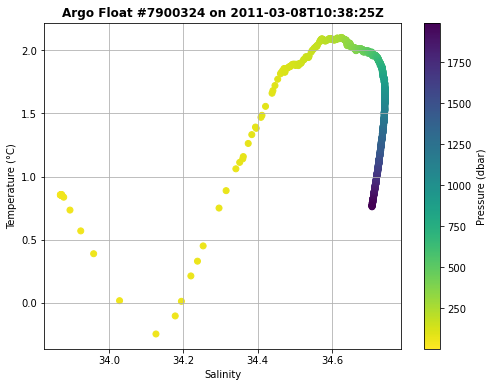

CPU times: user 1.45 s, sys: 1.2 s, total: 2.65 s
Wall time: 9.78 s


In [13]:
%%time
import matplotlib.pyplot as plt
from datetime import datetime
nprof = 200
def np_dt64_to_dt(in_datetime: np.datetime64) -> str:
    """Convert numpy datetime64 to datetime"""
    dt = datetime.fromtimestamp(in_datetime.astype(int) / 1e9)
    return dt.strftime("%Y-%m-%dT%H:%M:%SZ")

plt.figure(figsize=(8,6))

nprof = round(len(input_paths) / 2) #Selected profile
plt.scatter(data.PSAL_ADJUSTED[nprof], data.TEMP_ADJUSTED[nprof], c=data.PRES_ADJUSTED[nprof], cmap='viridis_r')
plt.xlabel('Salinity');
plt.ylabel('Temperature (°C)')

cbh = plt.colorbar();
cbh.set_label('Pressure (dbar)')

plt.grid()
plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold');
plt.show()

In [14]:
# cluster.close()
# client.close()